In [41]:
import numpy as np
from moviepy.editor import *
from PIL import Image
from matplotlib.pyplot import imshow, show

VID_FILE = 'omniverse.mp4'

In [26]:
clip = VideoFileClip(VID_FILE)
clip.ipython_display(width=240)

t:   0%|          | 7/7825 [00:00<02:01, 64.38it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


ValueError: The duration of video __temp__.mp4 (313.0) exceeds the 'maxduration' attribute. You can increase 'maxduration', by passing 'maxduration' parameterto ipython_display function.But note that embedding large videos may take all the memory away !

In [27]:
print('Frames/Second:', clip.reader.fps)
print('Frame Count:', clip.reader.nframes)
print('Video Length:', clip.duration)

Frames/Second: 25.0
Frame Count: 7826
Video Length: 313.0


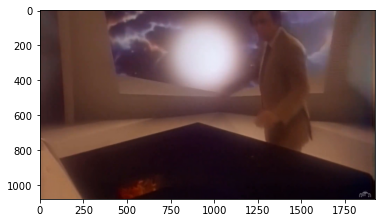

In [42]:
def print_frame(frame):
    img = Image.fromarray(frame)
    imshow(img)
    show()
    
print_frame(clip.get_frame(np.random.randint(0, clip.duration)))

In [21]:
def scene_changed(prev_frame, frame, delta_thresh=30):
    delta = abs(np.mean(prev_frame) - np.mean(frame))
    
    if delta > delta_thresh:
        return True
    return False

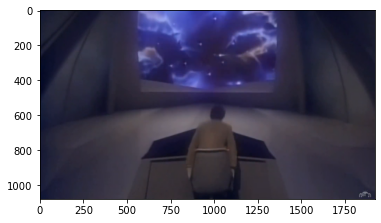

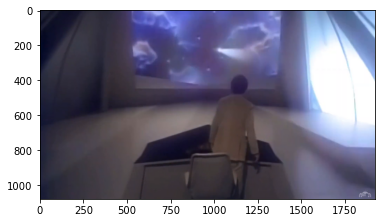

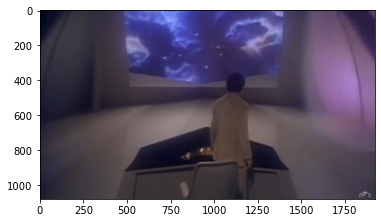

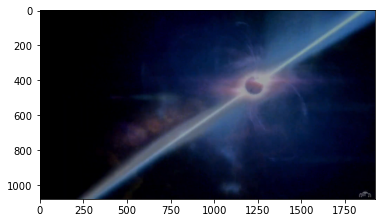

In [47]:
split_cnt = 0
for i in range(1, clip.reader.nframes):
    prev_frame = clip.get_frame(i-1)
    frame = clip.get_frame(i)
    
    if scene_changed(prev_frame, frame, delta_thresh=20):
        print_frame(frame)
        
        split_cnt += 1
        #_ = input('Press Enter to Continue')
        
    if split_cnt > 3:
        break